# testDeepctr

In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from deepctr_torch.models import DeepFM
from deepctr_torch.inputs import  SparseFeat, DenseFeat,get_feature_names
import torch
data = pd.read_csv('./criteo_sample.txt')

sparse_features = ['C' + str(i) for i in range(1, 27)]
dense_features = ['I'+str(i) for i in range(1, 14)]

data[sparse_features] = data[sparse_features].fillna('-1', )
data[dense_features] = data[dense_features].fillna(0,)
target = ['label']

In [4]:
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])

In [5]:
mms = MinMaxScaler(feature_range=(0,1))
data[dense_features] = mms.fit_transform(data[dense_features])

In [6]:
sparse_feature_columns = [SparseFeat(feat, data[feat].nunique())
                        for feat in sparse_features]
dense_feature_columns = [DenseFeat(feat, 1)
                      for feat in dense_features]

In [7]:
sparse_feature_columns = [SparseFeat(feat, dimension=1e6,use_hash=True) for feat in sparse_features]#The dimension can be set according to data
dense_feature_columns = [DenseFeat(feat, 1)
                      for feat in dense_features]

In [8]:
dnn_feature_columns = sparse_feature_columns + dense_feature_columns
linear_feature_columns = sparse_feature_columns + dense_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)


In [ ]:
train, test = train_test_split(data, test_size=0.2)
train_model_input = {name:train[name] for name in feature_names}

test_model_input = {name:test[name] for name in feature_names}


device = 'cpu'
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'

model = DeepFM(linear_feature_columns,dnn_feature_columns,task='binary',device=device)
model.compile("adam", "binary_crossentropy",
              metrics=['binary_crossentropy'], )

history = model.fit(train_model_input, train[target].values,
                    batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
pred_ans = model.predict(test_model_input, batch_size=256)

## deepctr_torch 测试din 

In [ ]:
import numpy as np

from deepctr_torch.models import DIN
from deepctr_torch.inputs import SparseFeat,VarLenSparseFeat,DenseFeat,get_feature_names


def get_xy_fd():

    feature_columns = [SparseFeat('user',3),SparseFeat(
        'gender', 2), SparseFeat('item', 3 + 1), SparseFeat('item_gender', 2 + 1),DenseFeat('score', 1)]
    feature_columns += [VarLenSparseFeat('hist_item',3+1, maxlen=4, embedding_name='item'),
                        VarLenSparseFeat('hist_item_gender',3+1, maxlen=4, embedding_name='item_gender')]

    behavior_feature_list = ["item", "item_gender"]
    uid = np.array([0, 1, 2])
    ugender = np.array([0, 1, 0])
    iid = np.array([1, 2, 3])  # 0 is mask value
    igender = np.array([1, 2, 1])  # 0 is mask value
    score = np.array([0.1, 0.2, 0.3])

    hist_iid = np.array([[1, 2, 3, 0], [1, 2, 3, 0], [1, 2, 0, 0]])
    hist_igender = np.array([[1, 1, 2, 0], [2, 1, 1, 0], [2, 1, 0, 0]])

    feature_dict = {'user': uid, 'gender': ugender, 'item': iid, 'item_gender': igender,
                    'hist_item': hist_iid, 'hist_item_gender': hist_igender, 'score': score}
    x = {name:feature_dict[name] for name in get_feature_names(feature_columns)}
    y = [1, 0, 1]
    return x, y, feature_columns, behavior_feature_list


if __name__ == "__main__":
    x, y, feature_columns, behavior_feature_list = get_xy_fd()
    model = DIN(feature_columns, behavior_feature_list, hist_len_max=4, )
    model.compile('adam', 'binary_crossentropy',
                  metrics=['binary_crossentropy'])
    history = model.fit(x, y, verbose=1, epochs=10, validation_split=0.5)

In [26]:
import pandas as pd
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from deepctr_torch.models import *
from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names
import torch

if __name__ == "__main__":
    data = pd.read_csv('./criteo_sample.txt')

    sparse_features = ['C' + str(i) for i in range(1, 27)]
    dense_features = ['I' + str(i) for i in range(1, 14)]

    data[sparse_features] = data[sparse_features].fillna('-1', )
    data[dense_features] = data[dense_features].fillna(0, )
    target = ['label']

    # 1.Label Encoding for sparse features,and do simple Transformation for dense features
    for feat in sparse_features:
        lbe = LabelEncoder()
        data[feat] = lbe.fit_transform(data[feat])
    mms = MinMaxScaler(feature_range=(0, 1))
    data[dense_features] = mms.fit_transform(data[dense_features])

    # 2.count #unique features for each sparse field,and record dense feature field name

    fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique())
                              for feat in sparse_features] + [DenseFeat(feat, 1,)
                                                              for feat in dense_features]

    dnn_feature_columns = fixlen_feature_columns
    linear_feature_columns = fixlen_feature_columns

    feature_names = get_feature_names(
        linear_feature_columns + dnn_feature_columns)

    # 3.generate input data for model

    train, test = train_test_split(data, test_size=0.2)
    train_model_input = {name:train[name] for name in feature_names}
    test_model_input = {name:test[name] for name in feature_names}

    # 4.Define Model,train,predict and evaluate

    device = 'cpu'
    use_cuda = False
    if use_cuda and torch.cuda.is_available():
        print('cuda ready...')
        device = 'cuda:0'

    model = DeepFM(linear_feature_columns=linear_feature_columns, dnn_feature_columns=dnn_feature_columns, task='binary',
                   l2_reg_embedding=1e-5, device=device)

    model.compile("adagrad", "binary_crossentropy",
                  metrics=["binary_crossentropy", "auc"],)
    model.fit(train_model_input, train[target].values,
              batch_size=256, epochs=10, validation_split=0.2, verbose=2)

    pred_ans = model.predict(test_model_input, 256)
    print("")
    print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
    print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))

cpu
Train on 128 samples, validate on 32 samples, 1 steps per epoch
Epoch 1/10
0s - loss:  0.6903 - binary_crossentropy:  0.6903 - auc:  0.5284 - val_binary_crossentropy:  0.6410 - val_auc:  0.5086
Epoch 2/10
0s - loss:  0.6170 - binary_crossentropy:  0.6170 - auc:  0.9711 - val_binary_crossentropy:  0.6034 - val_auc:  0.3829
Epoch 3/10
0s - loss:  0.4955 - binary_crossentropy:  0.4955 - auc:  0.9837 - val_binary_crossentropy:  0.5771 - val_auc:  0.3829
Epoch 4/10
0s - loss:  0.4074 - binary_crossentropy:  0.4074 - auc:  0.9751 - val_binary_crossentropy:  0.5644 - val_auc:  0.4057
Epoch 5/10
0s - loss:  0.3227 - binary_crossentropy:  0.3227 - auc:  0.9751 - val_binary_crossentropy:  0.5627 - val_auc:  0.4171
Epoch 6/10
0s - loss:  0.2393 - binary_crossentropy:  0.2393 - auc:  0.9924 - val_binary_crossentropy:  0.5745 - val_auc:  0.4400
Epoch 7/10
0s - loss:  0.1632 - binary_crossentropy:  0.1632 - auc:  0.9993 - val_binary_crossentropy:  0.5967 - val_auc:  0.4514
Epoch 8/10
0s - loss: 

In [28]:
type(train_model_input)

dict

In [ ]:
train

In [30]:
train_model_input.keys()

dict_keys(['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13'])

In [ ]:
train[target].values

In [44]:
pred_ans[:,0].shape,test[target].values[:,0].shape

((40,), (40,))

# 测试prroc

In [46]:
import pandas as pd
df_prroc=pd.DataFrame({'pred': pred_ans[:,0], 'label':test[target].values[:,0]})
df_prroc.to_pickle("./deepmodel_result/dcr_result/criteo_sample_result.pkl")

In [ ]:
df_prroc

In [51]:
import pickle as pkl
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import pylab as plt
import numpy as np


def draw_loss(file_train, file_valid):
    csv_file = csv.reader(open(file_train, 'r'))
    data_train = [row for row in csv_file]
    data_train = np.array(data_train, dtype=np.float32)

    csv_file2 = csv.reader(open(file_valid, 'r'))
    data_valid = [row for row in csv_file2]
    data_valid = np.array(data_valid, dtype=np.float32)

    plt.plot(data_train, 'b')
    plt.plot(data_valid, 'r')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.title('valid loss(r) and train loss(b)')
    plt.show()


def skl_pr(file_name):
    with open(file_name, 'rb') as pklfile:
        data_all = pkl.load(pklfile)
        precision, recall, threshold = precision_recall_curve(np.array(data_all['label']), 
                                                              np.array(data_all['pred']))
        plt.plot(recall, precision, label='pr')
        plt.title("PR curve")
        plt.ylabel('Precision')
        plt.xlabel('Recall')
        plt.legend()
        plt.show()


def skl_roc(file_name):
    with open(file_name, 'rb') as pklfile:
        data_all = pkl.load(pklfile)
        fpr, tpr, thresholds = roc_curve(np.array(data_all['label']), 
                                         np.array(data_all['pred']))  # [tru、pre]
        accuracy = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='%s: %.3f' % ('roc', accuracy))
        plt.plot([0, 1], [0, 1], '--k')
        plt.title("ROC curve")
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        #plt.legend(sign, 'best')
        plt.legend()
        plt.show()


def draw_pr_roc(file):
    with open(file, 'rb') as f:
        res = pkl.load(f)
        print(res)
        #print(res[1][0])

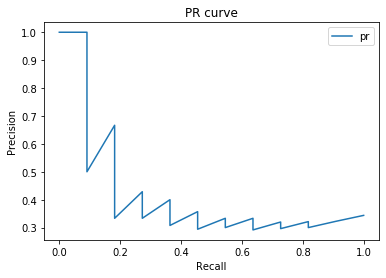

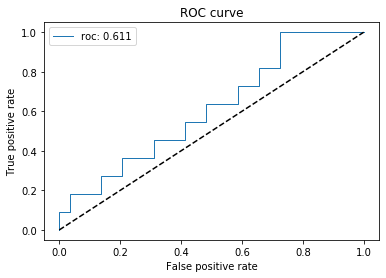

In [52]:
file_name = './deepmodel_result/dcr_result/criteo_sample_result.pkl'
skl_pr(file_name)
skl_roc(file_name)

# dcr应用oil数据

In [11]:
list(range(76))
data.columns

Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,      10,      11,      12,      13,      14,      15,
            16,      17,      18,      19,      20,      21,      22,      23,
            24,      25,      26,      27,      28,      29,      30,      31,
            32,      33,      34,      35,      36,      37,      38,      39,
            40,      41,      42,      43,      44,      45,      46,      47,
            48,      49,      50,      51,      52,      53,      54,      55,
            56,      57,      58,      59,      60,      61,      62,      63,
            64,      65,      66,      67,      68,      69,      70,      71,
            72,      73,      74,      75, 'label'],
      dtype='object')

In [12]:
data = pd.read_pickle('./df_train_76d_full.pkl')
dense_features =[0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,      10,      11,      12,      13,      14,      15,
            16,      17,      18,      19,      20,      21,      22,      23,
            24,      25,      26,      27,      28,      29,      30,      31,
            32,      33,      34,      35,      36,      37,      38,      39,
            40,      41,      42,      43,      44,      45,      46,      47,
            48,      49,      50,      51,      52,      53,      54,      55,
            56,      57,      58,      59,      60,      61,      62,      63,
            64,      65,      66,      67,      68,      69,      70,      71,
            72,      73,      74,      75,]
data[dense_features] = data[dense_features].fillna(0, )

In [16]:
data_train = pd.read_pickle('./df_train_76d_full.pkl')
data_test = pd.read_pickle('./df_test_76d_full.pkl')
data_val = pd.read_pickle('./df_val_76d_full.pkl')
data=pd.concat([data_train, data_test,data_val], axis=0, ignore_index=True)
data.to_pickle("./df_76d_full_50942.pkl")

## DFM

In [88]:
import pandas as pd
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from deepctr_torch.models import *
from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names
import torch

if __name__ == "__main__":
    data = pd.read_pickle('./df_76d_full_50942.pkl')
    sparse_features = []
    dense_features =[0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,      10,      11,      12,      13,      14,      15,
            16,      17,      18,      19,      20,      21,      22,      23,
            24,      25,      26,      27,      28,      29,      30,      31,
            32,      33,      34,      35,      36,      37,      38,      39,
            40,      41,      42,      43,      44,      45,      46,      47,
            48,      49,      50,      51,      52,      53,      54,      55,
            56,      57,      58,      59,      60,      61,      62,      63,
            64,      65,      66,      67,      68,      69,      70,      71,
            72,      73,      74,      75,]
    data[sparse_features] = data[sparse_features].fillna('-1', )
    data[dense_features] = data[dense_features].fillna(0, )
    target = ['label']

    # 1.Label Encoding for sparse features,and do simple Transformation for dense features
    for feat in sparse_features:
        lbe = LabelEncoder()
        data[feat] = lbe.fit_transform(data[feat])
    mms = MinMaxScaler(feature_range=(0, 1))
    data[dense_features] = mms.fit_transform(data[dense_features])

    # 2.count #unique features for each sparse field,and record dense feature field name

    fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique())
                              for feat in sparse_features] + [DenseFeat(feat, 1,)
                                                              for feat in dense_features]

    dnn_feature_columns = fixlen_feature_columns
    linear_feature_columns = fixlen_feature_columns

    feature_names = get_feature_names(
        linear_feature_columns + dnn_feature_columns)

    # 3.generate input data for model

    train, test = train_test_split(data, test_size=0.2)
    train_model_input = {name:train[name] for name in feature_names}
    test_model_input = {name:test[name] for name in feature_names}

    # 4.Define Model,train,predict and evaluate

    device = 'cpu'
    use_cuda = False
    if use_cuda and torch.cuda.is_available():
        print('cuda ready...')
        device = 'cuda:0'

    model = DeepFM(linear_feature_columns=linear_feature_columns, dnn_feature_columns=dnn_feature_columns, task='binary',
                   l2_reg_embedding=1e-5, device=device)

    model.compile("adagrad", "binary_crossentropy",
                  metrics=["binary_crossentropy", "auc"],)
    model.fit(train_model_input, train[target].values,
              batch_size=256, epochs=1000, validation_split=0.2, verbose=2)

    pred_ans = model.predict(test_model_input, 256)
    print("")
    print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
    print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))
    

cuda ready...
cuda:0
Train on 32602 samples, validate on 8151 samples, 128 steps per epoch
Epoch 1/1000
1s - loss:  0.6802 - binary_crossentropy:  0.6800 - auc:  0.5378 - val_binary_crossentropy:  0.6803 - val_auc:  0.5586
Epoch 2/1000
1s - loss:  0.6764 - binary_crossentropy:  0.6765 - auc:  0.5692 - val_binary_crossentropy:  0.6781 - val_auc:  0.5744
Epoch 3/1000
1s - loss:  0.6732 - binary_crossentropy:  0.6732 - auc:  0.5745 - val_binary_crossentropy:  0.6741 - val_auc:  0.5768
Epoch 4/1000
2s - loss:  0.6714 - binary_crossentropy:  0.6713 - auc:  0.5781 - val_binary_crossentropy:  0.6727 - val_auc:  0.5797
Epoch 5/1000
1s - loss:  0.6710 - binary_crossentropy:  0.6710 - auc:  0.5825 - val_binary_crossentropy:  0.6718 - val_auc:  0.5823
Epoch 6/1000
2s - loss:  0.6703 - binary_crossentropy:  0.6701 - auc:  0.5854 - val_binary_crossentropy:  0.6715 - val_auc:  0.5844
Epoch 7/1000
2s - loss:  0.6693 - binary_crossentropy:  0.6693 - auc:  0.5893 - val_binary_crossentropy:  0.6723 - va

KeyboardInterrupt: 

In [59]:
test_model_input

{0: 39862    0.636004
 15855    0.551560
 30228    0.627581
 43992    0.932762
 42282    0.455005
 41411    0.611100
 27383    0.624088
 33417    0.609140
 47264    0.224384
 9143     0.637037
 4895     0.647727
 27679    0.621101
 5902     0.405139
 34956    0.422998
 2650     0.604915
 29838    0.397811
 7188     0.406370
 18146    0.411119
 13886    0.557890
 41890    0.408989
 49545    0.410212
 24732    0.636997
 47078    0.401471
 21086    0.647696
 12060    0.446363
 30861    0.599563
 41267    0.626340
 22530    0.605697
 40343    0.361468
 35212    0.606958
            ...   
 35912    0.847267
 3967     0.598666
 12997    0.470628
 44332    0.608564
 47525    0.601400
 12385    0.579206
 17234    0.395630
 45759    0.357429
 21250    0.854392
 21269    0.572015
 47872    0.408768
 50799    0.659107
 4954     0.430807
 11645    0.642146
 47374    0.403227
 44361    0.612768
 27736    0.306560
 21175    0.375727
 46321    0.426773
 28625    0.704958
 2982     0.644102
 1426    

In [60]:
test[target]#index和test_model_input一致

,label
39862,1
15855,1
30228,1
43992,0
42282,0
41411,0
27383,1
33417,0
47264,1
9143,0


### DFM PR ROC

In [67]:
import pandas as pd
df_prroc=pd.DataFrame({'pred': pred_ans[:,0], 'label':test[target].values[:,0]})
df_prroc.to_pickle("./deepmodel_result/dcr_result/oil_DFM_result_10epoch.pkl")

In [68]:
roc_auc_score(test[target].values, pred_ans)

0.5947749215447042

In [79]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
with open('./deepmodel_result/dcr_result/oil_DFM_result_10epoch.pkl', 'rb') as pklfile1:

    data_all = pkl.load(pklfile1)
    fpr, tpr, thresholds = roc_curve(np.array(data_all['label']), 
                                         np.array(data_all['pred']))
    print(auc(fpr, tpr))

0.5947749215447042


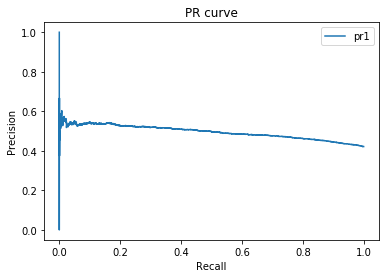

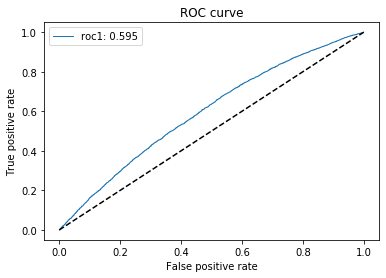

In [80]:
import pickle as pkl
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import pylab as plt
import numpy as np
def skl_pr(file_name1):
    with open(file_name1, 'rb') as pklfile1:

        data_all1 = pkl.load(pklfile1)
        precision1, recall1, threshold1 = precision_recall_curve(np.array(data_all1['label']), 
                                                              np.array(data_all1['pred']))
#         data_all2 = pkl.load(pklfile2)
#         precision2, recall2, threshold2 = precision_recall_curve(np.array(data_all2['label']).T[1], 
#                                                               np.array(data_all2['pred'].T[1]))
#         data_all3 = pkl.load(pklfile3)
#         precision3, recall3, threshold3 = precision_recall_curve(np.array(data_all3['label']).T[1], 
#                                                               np.array(data_all3['pred'].T[1]))
        
#         data_all4 = pkl.load(pklfile4)
#         precision4, recall4, threshold4 = precision_recall_curve(np.array(data_all4['label']).T[1], 
#                                                               np.array(data_all4['pred'].T[1]))
        
        plt.plot(recall1, precision1, label='pr1')
#         plt.plot(recall2, precision2, label='pr2')
#         plt.plot(recall3, precision3, label='pr3')
#         plt.plot(recall4, precision4, label='pr4')
        plt.title("PR curve")
        plt.ylabel('Precision')
        plt.xlabel('Recall')
        plt.legend()
#         plt.savefig("PR.png")
        plt.show()
def skl_roc(file_name1):#,file_name2,file_name3,filename4):
    with open(file_name1, 'rb') as pklfile1:#,open(file_name2, 'rb') as pklfile2,open(file_name3, 'rb') as pklfile3,open(file_name4, 'rb') as pklfile4:
        
        data_all1 = pkl.load(pklfile1)
        fpr1, tpr1, thresholds1 = roc_curve(np.array(data_all1['label']), 
                                         np.array(data_all1['pred']))  # [tru、pre]
        accuracy1 = auc(fpr1, tpr1)
        
#         data_all2 = pkl.load(pklfile2)
#         fpr2, tpr2, thresholds2 = roc_curve(np.array(data_all2['label']).T[1], 
#                                          np.array(data_all2['pred'].T[1]))  # [tru、pre]
#         accuracy2 = auc(fpr2, tpr2)        
        
#         data_all3 = pkl.load(pklfile3)
#         fpr3, tpr3, thresholds3 = roc_curve(np.array(data_all3['label']).T[1], 
#                                          np.array(data_all3['pred'].T[1]))  # [tru、pre]
#         accuracy3 = auc(fpr3, tpr3)  
        
#         data_all4 = pkl.load(pklfile4)
#         fpr4, tpr4, thresholds4 = roc_curve(np.array(data_all4['label']).T[1], 
#                                          np.array(data_all4['pred'].T[1]))  # [tru、pre]
#         accuracy4 = auc(fpr4, tpr4)  
        
        plt.plot(fpr1, tpr1, lw=1, label='%s: %.3f' % ('roc1', accuracy1))
#         plt.plot(fpr2, tpr2, lw=1, label='%s: %.3f' % ('roc2', accuracy2))
#         plt.plot(fpr3, tpr3, lw=1, label='%s: %.3f' % ('roc3', accuracy3))
#         plt.plot(fpr4, tpr4, lw=1, label='%s: %.3f' % ('roc4', accuracy4))


        plt.plot([0, 1], [0, 1], '--k')
        plt.title("ROC curve")
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        #plt.legend(sign, 'best')
        plt.legend()
        plt.savefig("ROC.png")
        plt.show()
# file_name1='result/cnn_result/Time_cnn_all_gap_slice_0_total.pkl'
# file_name2= 'result/cnn_result/Time_cnn_all_gap_slice_0_total_tune.pkl'
# file_name3= 'result/cnn_result/Time_cnn_all_gap_slice_0_total_tune4.pkl'
# file_name4= 'result/cnn_result/Time_cnn_all_gap_slice_0_total_tune_focalloss.pkl'
# skl_pr(file_name1,file_name2,file_name3,file_name4)
# skl_roc(file_name1,file_name2,file_name3,file_name4)
# # draw_pr_roc(file_name)
file_name = './deepmodel_result/dcr_result/oil_DFM_result_10epoch.pkl'
skl_pr(file_name)
skl_roc(file_name)

## DCN

In [82]:
import pandas as pd
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from deepctr_torch.models import *
from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names
import torch

if __name__ == "__main__":
    data = pd.read_pickle('./df_76d_full_50942.pkl')
    sparse_features = []
    dense_features =[0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,      10,      11,      12,      13,      14,      15,
            16,      17,      18,      19,      20,      21,      22,      23,
            24,      25,      26,      27,      28,      29,      30,      31,
            32,      33,      34,      35,      36,      37,      38,      39,
            40,      41,      42,      43,      44,      45,      46,      47,
            48,      49,      50,      51,      52,      53,      54,      55,
            56,      57,      58,      59,      60,      61,      62,      63,
            64,      65,      66,      67,      68,      69,      70,      71,
            72,      73,      74,      75,]
    data[sparse_features] = data[sparse_features].fillna('-1', )
    data[dense_features] = data[dense_features].fillna(0, )
    target = ['label']

    # 1.Label Encoding for sparse features,and do simple Transformation for dense features
    for feat in sparse_features:
        lbe = LabelEncoder()
        data[feat] = lbe.fit_transform(data[feat])
    mms = MinMaxScaler(feature_range=(0, 1))
    data[dense_features] = mms.fit_transform(data[dense_features])

    # 2.count #unique features for each sparse field,and record dense feature field name

    fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique())
                              for feat in sparse_features] + [DenseFeat(feat, 1,)
                                                              for feat in dense_features]

    dnn_feature_columns = fixlen_feature_columns
    linear_feature_columns = fixlen_feature_columns

    feature_names = get_feature_names(
        linear_feature_columns + dnn_feature_columns)

    # 3.generate input data for model

    train, test = train_test_split(data, test_size=0.2)
    train_model_input = {name:train[name] for name in feature_names}
    test_model_input = {name:test[name] for name in feature_names}

    # 4.Define Model,train,predict and evaluate

    device = 'cpu'
    use_cuda = False
    if use_cuda and torch.cuda.is_available():
        print('cuda ready...')
        device = 'cuda:0'

    model = DCN(dnn_feature_columns=dnn_feature_columns, task='binary',
                   l2_reg_embedding=1e-5, device=device)

    model.compile("adagrad", "binary_crossentropy",
                  metrics=["binary_crossentropy", "auc"],)
    model.fit(train_model_input, train[target].values,
              batch_size=256, epochs=10, validation_split=0.2, verbose=2)

    pred_ans = model.predict(test_model_input, 256)
    print("")
    print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
    print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))

cpu
Train on 32602 samples, validate on 8151 samples, 128 steps per epoch
Epoch 1/10
7s - loss:  0.6802 - binary_crossentropy:  0.6802 - auc:  0.5246 - val_binary_crossentropy:  0.6751 - val_auc:  0.5650
Epoch 2/10
9s - loss:  0.6755 - binary_crossentropy:  0.6754 - auc:  0.5720 - val_binary_crossentropy:  0.6672 - val_auc:  0.5847
Epoch 3/10
9s - loss:  0.6720 - binary_crossentropy:  0.6721 - auc:  0.5850 - val_binary_crossentropy:  0.6657 - val_auc:  0.5893
Epoch 4/10
7s - loss:  0.6703 - binary_crossentropy:  0.6702 - auc:  0.5892 - val_binary_crossentropy:  0.6645 - val_auc:  0.5930
Epoch 5/10
10s - loss:  0.6687 - binary_crossentropy:  0.6687 - auc:  0.5934 - val_binary_crossentropy:  0.6644 - val_auc:  0.5956
Epoch 6/10
14s - loss:  0.6677 - binary_crossentropy:  0.6675 - auc:  0.5966 - val_binary_crossentropy:  0.6634 - val_auc:  0.5971
Epoch 7/10
15s - loss:  0.6670 - binary_crossentropy:  0.6669 - auc:  0.6002 - val_binary_crossentropy:  0.6618 - val_auc:  0.6003
Epoch 8/10
17

### DCN PR ROC

In [83]:
import pandas as pd
df_prroc=pd.DataFrame({'pred': pred_ans[:,0], 'label':test[target].values[:,0]})
df_prroc.to_pickle("./deepmodel_result/dcr_result/oil_DCN_result_10epoch.pkl")

In [84]:
roc_auc_score(test[target].values, pred_ans)

0.6136851338365664

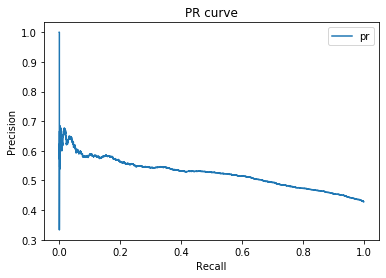

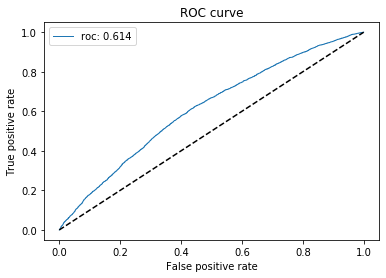

In [86]:
import pickle as pkl
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import pylab as plt
import numpy as np


def draw_loss(file_train, file_valid):
    csv_file = csv.reader(open(file_train, 'r'))
    data_train = [row for row in csv_file]
    data_train = np.array(data_train, dtype=np.float32)

    csv_file2 = csv.reader(open(file_valid, 'r'))
    data_valid = [row for row in csv_file2]
    data_valid = np.array(data_valid, dtype=np.float32)

    plt.plot(data_train, 'b')
    plt.plot(data_valid, 'r')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.title('valid loss(r) and train loss(b)')
    plt.show()


def skl_pr(file_name):
    with open(file_name, 'rb') as pklfile:
        data_all = pkl.load(pklfile)
        precision, recall, threshold = precision_recall_curve(np.array(data_all['label']), 
                                                              np.array(data_all['pred']))
        plt.plot(recall, precision, label='pr')
        plt.title("PR curve")
        plt.ylabel('Precision')
        plt.xlabel('Recall')
        plt.legend()
        plt.show()


def skl_roc(file_name):
    with open(file_name, 'rb') as pklfile:
        data_all = pkl.load(pklfile)
        fpr, tpr, thresholds = roc_curve(np.array(data_all['label']), 
                                         np.array(data_all['pred']))  # [tru、pre]
        accuracy = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='%s: %.3f' % ('roc', accuracy))
        plt.plot([0, 1], [0, 1], '--k')
        plt.title("ROC curve")
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        #plt.legend(sign, 'best')
        plt.legend()
        plt.show()


def draw_pr_roc(file):
    with open(file, 'rb') as f:
        res = pkl.load(f)
        print(res)
        #print(res[1][0])
file_name = './deepmodel_result/dcr_result/oil_DCN_result_10epoch.pkl'
skl_pr(file_name)
skl_roc(file_name)

# 输出DCN&DFM 1000epoch的pr和ROC

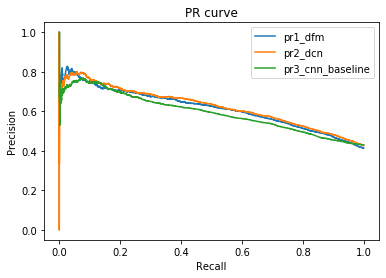

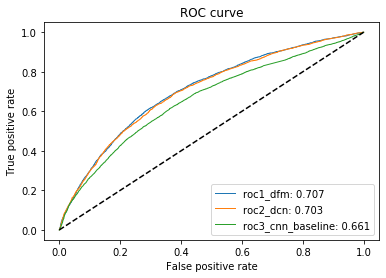

In [11]:
import pickle as pkl
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import pylab as plt
import numpy as np
def skl_pr(file_name1,file_name2,file_name3):
    with open(file_name1, 'rb') as pklfile1,open(file_name2, 'rb') as pklfile2,open(file_name3, 'rb') as pklfile3:

        data_all1 = pkl.load(pklfile1)
        precision1, recall1, threshold1 = precision_recall_curve(np.array(data_all1['label']), 
                                                              np.array(data_all1['pred']))
        data_all2 = pkl.load(pklfile2)
        precision2, recall2, threshold2 = precision_recall_curve(np.array(data_all2['label']), 
                                                              np.array(data_all2['pred']))
        data_all3 = pkl.load(pklfile3)
        precision3, recall3, threshold3 = precision_recall_curve(np.array(data_all3['label'].T[1]), 
                                                              np.array(data_all3['pred'].T[1]))
        
#         data_all4 = pkl.load(pklfile4)
#         precision4, recall4, threshold4 = precision_recall_curve(np.array(data_all4['label']).T[1], 
#                                                               np.array(data_all4['pred'].T[1]))
        
        plt.plot(recall1, precision1, label='pr1_dfm')
        plt.plot(recall2, precision2, label='pr2_dcn')
        plt.plot(recall3, precision3, label='pr3_cnn_baseline')
#         plt.plot(recall4, precision4, label='pr4')
        plt.title("PR curve")
        plt.ylabel('Precision')
        plt.xlabel('Recall')
        plt.legend()
        plt.savefig("PR_1000.png")
        plt.show()
def skl_roc(file_name1,file_name2,file_name3):#,filename4):
    with open(file_name1, 'rb') as pklfile1,open(file_name2, 'rb') as pklfile2,open(file_name3, 'rb') as pklfile3:#,open(file_name4, 'rb') as pklfile4:
        
        data_all1 = pkl.load(pklfile1)
        fpr1, tpr1, thresholds1 = roc_curve(np.array(data_all1['label']), 
                                         np.array(data_all1['pred']))  # [tru、pre]
        accuracy1 = auc(fpr1, tpr1)
        
        data_all2 = pkl.load(pklfile2)
        fpr2, tpr2, thresholds2 = roc_curve(np.array(data_all2['label']), 
                                         np.array(data_all2['pred']))  # [tru、pre]
        accuracy2 = auc(fpr2, tpr2)        
        
        data_all3 = pkl.load(pklfile3)
        fpr3, tpr3, thresholds3 = roc_curve(np.array(data_all3['label'].T[1]), 
                                         np.array(data_all3['pred'].T[1]))  # [tru、pre]
        accuracy3 = auc(fpr3, tpr3)  
        
#         data_all4 = pkl.load(pklfile4)
#         fpr4, tpr4, thresholds4 = roc_curve(np.array(data_all4['label']).T[1], 
#                                          np.array(data_all4['pred'].T[1]))  # [tru、pre]
#         accuracy4 = auc(fpr4, tpr4)  
        
        plt.plot(fpr1, tpr1, lw=1, label='%s: %.3f' % ('roc1_dfm', accuracy1))
        plt.plot(fpr2, tpr2, lw=1, label='%s: %.3f' % ('roc2_dcn', accuracy2))
        plt.plot(fpr3, tpr3, lw=1, label='%s: %.3f' % ('roc3_cnn_baseline', accuracy3))
#         plt.plot(fpr4, tpr4, lw=1, label='%s: %.3f' % ('roc4', accuracy4))


        plt.plot([0, 1], [0, 1], '--k')
        plt.title("ROC curve")
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        #plt.legend(sign, 'best')
        plt.legend()
        plt.savefig("ROC_1000.png")
        plt.show()
# file_name1='result/cnn_result/Time_cnn_all_gap_slice_0_total.pkl'
# file_name2= 'result/cnn_result/Time_cnn_all_gap_slice_0_total_tune.pkl'
# file_name3= 'result/cnn_result/Time_cnn_all_gap_slice_0_total_tune4.pkl'
# file_name4= 'result/cnn_result/Time_cnn_all_gap_slice_0_total_tune_focalloss.pkl'
# skl_pr(file_name1,file_name2,file_name3,file_name4)
# skl_roc(file_name1,file_name2,file_name3,file_name4)
# # draw_pr_roc(file_name)
file_name1 = './deepmodel_result/dcr_result/oil_DFM_result_1000epoch.pkl'
file_name2 = './deepmodel_result/dcr_result/oil_DCN_result_1000epoch.pkl'
file_name3 = '/disk3/zk/aboutoil/Shengli/oil_cnn_clean/result/cnn_result/Time_cnn_all_gap_slice_0_total.pkl'
skl_pr(file_name1,file_name2,file_name3)
skl_roc(file_name1,file_name2,file_name3)